# Code that takes in COLMAP results of a scene ([2D,3D] points), obtains a coarse DEM in the region of interest, scales to [m] of this coarse DEM, then refines to finer point like Lidar data



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
#import numba as nb
import cv2
from scipy.interpolate import interp2d, interp1d
from scipy.interpolate import griddata
from scipy.interpolate import RegularGridInterpolator,LinearNDInterpolator
from mpl_toolkits import mplot3d
import matplotlib
import elevation
from tqdm import tqdm
import numdifftools
%matplotlib widget
from memory_profiler import profile
from astropy.nddata import block_reduce
import _ssl

### Read in Point Cloud

In [2]:
cwd = os.getcwd()
file_pt =os.path.join(cwd,'LocalEasy/images/fused.ply')
pcd = o3d.io.read_point_cloud(file_pt)
pcd_points=np.array(pcd.points)
pcd_colors=np.array(pcd.colors)
pcd_normals=np.array(pcd.normals)

#o3d.visualization.draw_geometries([pcd])

### Read in Sparse 3D points and 2D points

In [3]:
point3dfile = os.path.join(cwd,'LocalEasy/points3D-sparse.txt')
point2dfile = os.path.join(cwd,'LocalEasy/images-sparse.txt')
with open(point3dfile,'r') as f:
    data3d = f.readlines()
with open(point2dfile,'r') as f:
    data2d = f.readlines()

### Allocate all the 2D variables

In [4]:
n_images = int(len(data2d)/2) 
image_id = [] ; camera_id = [] ; camera_name = []
qw=[] ; qx=[] ; qy = []; qz = []; tx = []; ty = []; tz = []
for i in range(n_images):
    image_id.append(data2d[int(i*2)].split(' ')[0])
    qw.append(data2d[int(i*2)].split(' ')[1])
    qx.append(data2d[int(i*2)].split(' ')[2])
    qy.append(data2d[int(i*2)].split(' ')[3])
    qz.append(data2d[int(i*2)].split(' ')[4])
    tx.append(data2d[int(i*2)].split(' ')[5])
    ty.append(data2d[int(i*2)].split(' ')[6])
    tz.append(data2d[int(i*2)].split(' ')[7])
    camera_id.append(data2d[int(i*2)].split(' ')[8])
    camera_name.append(data2d[int(i*2)].split(' ')[9])
print(camera_id[0])
print(camera_name[0])

1
2018062FA_f01r01_20180620T172252Z_M1010300.jpg



### 2D Keypoint Info

In [5]:
n_images = int(len(data2d)/2) 
kx=[] ; ky = []; kp_p3d_id = [] ; kp_image_id = []
for i in range(n_images):
    x = data2d[int(i*2 + 1 )].split(' ')
    n3d = int(len(x)/3)
    for j in range(n3d):
        kx.append(x[3*j])
        ky.append(x[3*j+1])
        if(i==n_images-1 and j==n3d-1):
             kp_p3d_id.append(x[3*j+2].split('\n')[0])
        else:
            kp_p3d_id.append(x[3*j+2])
        kp_image_id.append(int(i))

### Allocate the Sparse 3D variables

In [6]:
##   POINT3D_ID, X, Y, Z, R, G, B, ERROR, TRACK[] as (IMAGE_ID, POINT2D_IDX)
point3d_id = [] ; x3d = [] ; y3d = [] ; z3d = [] ; red = [] ; green = [] ; blue = [] ; error = [] 
point3d_image_ref = [] ; point3d_2d_ref = []
nlines = len(data3d)
for i in range(nlines):
    x= data3d[i].split(' ')
    point3d_id.append(x[0])
    x3d.append(x[1])
    y3d.append(x[2])
    z3d.append(x[3])
    red.append(x[4])
    green.append(x[5])
    blue.append(x[6])
    error.append(x[7])
    ndetect = int((len(x) - 8)/2)
    for j in range(ndetect):
        point3d_image_ref.append(x[8 + 2*j]) 
        if(j==ndetect-1):
            point3d_2d_ref.append(x[9 + 2*j].split('\n')[0])
        else:
            point3d_2d_ref.append(x[9 + 2*j])

### Take each image and combine kx,ky [the key point locations in the 2d-image] with the 3D [Z]
### 1. Sort 'kp_image_id' -> kx,ky,kp_p3d_id 
### 2. For kp_p3d_id, search through the [nlines] of point3d_id and get kpz

In [7]:
kx=np.array(kx)
ky=np.array(ky)

kp_p3d_id=np.array(kp_p3d_id)
kp_image_id=np.array(kp_image_id)

idx = np.argsort(kp_image_id)
kp_image_id=kp_image_id[idx]
kp_p3d_id=kp_p3d_id[idx]
kx=kx[idx]
ky=ky[idx]

### Numba Fast Searching

In [8]:
#@nb.jit(fastmath=True)
def numba_list(kp_p3d_id,kp_image_id,kx,ky,point3d_id,z3d,y3d,x3d):
    kz = np.ones(len(kp_p3d_id))*-100000
    print(kz[-10:])
    kx_x3d = np.zeros(len(kp_p3d_id))
    ky_y3d = np.zeros(len(kp_p3d_id))
    image_0 = 0
    count=0
    for i in range(len(kp_p3d_id)):
                image = int(kp_image_id[i])
                #print(count)
                #print(image,image<=0)
                if(image == 0 ):
                    if(kp_p3d_id[i]!=-1):
                        for j in range(len(point3d_id)):
                            if(kp_p3d_id[i] == point3d_id[j]):
                                kz[i] = (z3d[j])
                                kx_x3d[i] = x3d[j]
                                ky_y3d[i] = y3d[j]
                    else:
                        kz[i] = np.nan
                        kx_x3d[i] = np.nan
                        ky_y3d[i] = np.nan
    return(kz,kx_x3d,ky_y3d)

### 3D List to array

In [9]:
image1_file = os.path.join(cwd,'LocalEasy/images/2018062FA_f01r01_20180620T172252Z_M1010300.jpg')#'#01MAY15WV031200015MAY01160357-M1BS-500648062030_01_P001_________GA_E0AAAAAAKAAK0_lv1_0-3k_0-3k_sub.png')
image1 = cv2.imread(image1_file)

z3d=np.array(z3d,dtype=np.float64)
y3d=np.array(y3d,dtype=np.float64)
x3d=np.array(x3d,dtype=np.float64)
kx = np.array(kx,dtype=np.float64)
ky = np.array(ky,dtype=np.float64)
kp_p3d_id=np.array(kp_p3d_id,dtype=np.int32)
point3d_id=np.array(point3d_id,dtype=np.float64)

# flip the y values of the keypoints upside down
ky=abs(ky-image1.shape[0]+1)

kz,kx_x3d,ky_y3d = numba_list(kp_p3d_id,kp_image_id,kx,ky,point3d_id,z3d,y3d,x3d)
print(kx_x3d.shape,kx.shape,kp_p3d_id.shape)

[-100000. -100000. -100000. -100000. -100000. -100000. -100000. -100000.
 -100000. -100000.]
(116442,) (116442,) (116442,)


### 2D data to arrays

In [10]:
kz = np.array(kz,dtype=np.float64)
kx_x3d=np.array(kx_x3d,dtype=np.float64)
ky_y3d=np.array(ky_y3d,dtype=np.float64)

#x = np.array(kp_p3d_id<0)
x = np.logical_or(kp_p3d_id<0,kz==-100000)
ky_0 = ky[x==False] 
kx_0 = kx[x==False] 
kp_p3d_id_0 = kp_p3d_id[x==False]
kz_0 = kz[x==False]
kx_x3d_0 = kx_x3d[x==False]
ky_y3d_0 = ky_y3d[x==False]
print(kx_x3d_0[0:10])
print(kz_0[0:10],kz_0.shape)

#ky_y3d_0=ky_y3d_0[::-1]

[ 1.40766173  1.40779996 -3.95504924 -3.98214808 -3.33650825 -3.12885039
  1.23605618 -3.39526216  5.49950557 -3.13276843]
[11.76585868 11.76334437  9.87854968  9.9373921  11.8349131  11.7914337
 11.78943445 11.74303253 12.00920577 11.49988794] (2703,)


### Now we want to allocate vectors lon,lat, each with length kx_0.shape
### These will store the positions of the matches keypoints

In [11]:
#This section  is for LocalEasy data set
"""
min_lon = -81.692832 
min_lat = 30.330339 
max_lon = -81.68375 
max_lat = 30.335839
"""

image1_file = os.path.join(cwd,'LocalEasy/images/2018062FA_f01r01_20180620T172252Z_M1010300.jpg')#'#01MAY15WV031200015MAY01160357-M1BS-500648062030_01_P001_________GA_E0AAAAAAKAAK0_lv1_0-3k_0-3k_sub.png')
image1 = cv2.imread(image1_file)
print(image1.shape)

lon_tl = -70.64722
lon_tr = -70.64611
lon_bl = -70.64777
lon_br = -70.64714

interp_lon_vert_left = np.linspace(lon_bl,lon_tl,image1.shape[1]) 
interp_lon_vert_right = np.linspace(lon_br,lon_tr,image1.shape[1]) 
interp_lon_hor_top = np.linspace(lon_tl,lon_tr,image1.shape[1]) 
interp_lon_hor_btm = np.linspace(lon_bl,lon_br,image1.shape[1]) 

lat_tl = 41.53518
lat_tr = 41.53439
lat_bl = 41.53459
lat_br = 41.53405

interp_lat_vert_left = np.linspace(lat_bl,lat_tl,image1.shape[0]) 
interp_lat_vert_right = np.linspace(lat_br,lat_tr,image1.shape[0]) 
interp_lat_hor_top = np.linspace(lat_tl,lat_tr,image1.shape[0]) 
interp_lat_hor_btm = np.linspace(lat_bl,lat_br,image1.shape[0]) 

lon2d = np.zeros((image1.shape[0],image1.shape[1]))
lat2d = np.zeros((image1.shape[0],image1.shape[1]))

for i in tqdm(range(image1.shape[0])):
        lon2d[i,:] = np.linspace(interp_lon_vert_left[i],interp_lon_vert_right[i],image1.shape[1])
        lat2d[i,:] = np.linspace(interp_lat_vert_left[i],interp_lat_vert_right[i],image1.shape[1])
    
#lat2d=lat2d[::-1,:]
#lon2d=lon2d[::-1,:]
        
#fig=plt.figure()
#plt.imshow(lon2d)
#display(fig)

#print(lon2d[0:10,0])     
#print(lat2d[0:10,0])     
"""
min_lon = -81.692832 
min_lat = 30.330339 
max_lon = -81.68375 
max_lat = 30.335839

image1_file = os.path.join(cwd,'LocalEasy/images/2018062FA_f01r01_20180620T172252Z_M1010300.jpg')#'#01MAY15WV031200015MAY01160357-M1BS-500648062030_01_P001_________GA_E0AAAAAAKAAK0_lv1_0-3k_0-3k_sub.png')
image1 = cv2.imread(image1_file)

lon1d=np.linspace(min_lon,max_lon,image1.shape[1])
lat1d=np.linspace(min_lat,max_lat,image1.shape[0])

# Flig latitude as image is upside down for validation
lat1d=lat1d[::-1]

print(lon1d.shape,lat1d.shape)

#mesh the lon/lat of image 1
lon2d,lat2d = np.meshgrid(lon1d,lat1d)
"""
# indices of pixels
idx = np.linspace(0,image1.shape[1]-1,image1.shape[1])
idy = np.linspace(0,image1.shape[0]-1,image1.shape[0])


interplon=RegularGridInterpolator((idy,idx),lon2d)
interplat=RegularGridInterpolator((idy,idx),lat2d)


(3264, 4352, 3)


100%|██████████| 3264/3264 [00:00<00:00, 11476.08it/s]


### Now we create a lon/lat/z kepypoint group for the sparse points

In [12]:
kp_sparse = np.zeros((3,len(kx_0)))
kp_sparse[2,:] = kz_0

#for i in range(len(kx_0)):
#    kp_sparse[0,i] = interplon(ky_0[i],kx_0[i])
#    kp_sparse[1,i] = interplat(ky_0[i],kx_0[i])
kp_sparse[0,:] = interplon((ky_0[:],kx_0[:]))
kp_sparse[1,:] = interplat((ky_0[:],kx_0[:]))

    
kxy = np.zeros((2,len(kx_0)))
kxy[0,:] = kx_0
kxy[1,:] = ky_0

#fig = plt.figure()
#plt.scatter(kp_sparse[0,:],kp_sparse[1,:])
#display(fig)

### Let is try griddata instead of interpolate
#### We already have the lon/lat interpolation function of [keypoints] -> [lon,lat].
#### Let's try that on the dense data points and try google maps

In [13]:
#dense3dfile = os.path.join(cwd,'CORE3D/Building_1/points3D.txt')
dense3dfile = os.path.join(cwd,'LocalEasy/points3D.txt')
with open(dense3dfile,'r') as f:
    dense3d = f.readlines()
    
##   POINT3D_ID, X, Y, Z, R, G, B, ERROR, TRACK[] as (IMAGE_ID, POINT2D_IDX)
dense_point3d_id = [] ; dense_x3d = [] ; dense_y3d = [] ; dense_z3d = [] 
dense_red = [] ; dense_green = [] ; dense_blue = [] 
nlines = len(dense3d)
for i in range(nlines):
    x= dense3d[i].split(' ')
    dense_point3d_id.append(x[0])
    dense_x3d.append(x[1])
    dense_y3d.append(x[2])
    dense_z3d.append(x[3])
    dense_red.append(x[4])
    dense_green.append(x[5])
    dense_blue.append(x[6])

In [14]:
#### Here we determine if the dense points [x,y] are contained within the sparse points [x,y]
#### If, so, we can interpolate like before. 
#### [X,Y] [interp] -> [kpx,kpy]
#### We already have: [kpx,kpy] [interp] -> [lon,lat]

In [15]:
dense_x3d=np.array(dense_x3d,dtype=np.float64)
dense_y3d=np.array(dense_y3d,dtype=np.float64)
dense_z3d=np.array(dense_z3d,dtype=np.float64)
print(dense_z3d.shape,dense_y3d.shape,dense_x3d.shape)

#dense_y3d=dense_y3d[::-1]


(382851,) (382851,) (382851,)


In [16]:
#Griddata for kx_0,ky_0 to get the respective lon and lat for these
idy = np.linspace(0,image1.shape[0]-1,image1.shape[0])
idx = np.linspace(0,image1.shape[1]-1,image1.shape[1])
#indices = np.zeros((len(idx),2))
#indicesx,indicesy=np.meshgrid(idx,idy)
#px=np.zeros((len(indicesx.flatten()),2))
#px[:,0] = indicesx.flatten()
#px[:,1] = indicesy.flatten()

#lon_kpts_0 = griddata(px,lon2d.flatten(),(kx_0,ky_0))
interpKPtoLon = RegularGridInterpolator((idy,idx),lon2d[:,:])
interpKPtoLat = RegularGridInterpolator((idy,idx),lat2d[:,:])
lon_kpts_0 = interpKPtoLon((ky_0,kx_0))
lat_kpts_0 = interpKPtoLat((ky_0,kx_0))

#fig=plt.figure()
#plt.scatter(lon_kpts_0,lat_kpts_0)
#display(fig)

In [17]:
# Interpolate the World [X,Y] onto our previously derived lon,lat values at the matching keypoints
interpXtoLon = LinearNDInterpolator((ky_y3d_0,kx_x3d_0),lon_kpts_0)
interpXtoLat = LinearNDInterpolator((ky_y3d_0,kx_x3d_0),lat_kpts_0)

In [18]:
# Validate that keypoints kx_0,ky_0 actually line up with lon_kpts_0 and lat_kpts_0
image1 = cv2.imread(image1_file)
#fig = plt.figure()
#for i in range(len(kx_0)):
#    cv2.circle(image1,(int(kx_0[i]),int(ky_0[i])),5,(255,0,0),15)
#plt.imshow(image1,aspect='auto')
#plt.title('Image 1 Key-Points')
#display(fig)
#plt.show()

print(kx_0[0],ky_0[0])
print(lon_kpts_0[0],lat_kpts_0[0])
print(kx_x3d_0[0],ky_y3d_0[0])
print('----')
print(kx_0[1],ky_0[1])
print(lon_kpts_0[1],lat_kpts_0[1])
print(kx_x3d_0[1],ky_y3d_0[1])

idx=np.argsort(kx_0)
kx_test=kx_0[idx]
ky_test=ky_0[idx]
kx_x3d_test=kx_x3d_0[idx]
ky_y3d_test=ky_y3d_0[idx]

idx=np.argsort(ky_0)
kx_test=kx_0[idx]
ky_test=ky_0[idx]
kx_x3d_test=kx_x3d_0[idx]
ky_y3d_test=ky_y3d_0[idx]


print(kx_test[0],kx_x3d_test[0])
print(ky_test[0],ky_y3d_test[0])

print(kx_test[-1],kx_x3d_test[-1])
print(ky_test[-1],ky_y3d_test[-1])


2695.4912109375 2504.5240478515625
-70.646891947629 41.5345894434563
1.4076617290123057 -4.258072516655903
----
2695.4912109375 2504.5240478515625
-70.646891947629 41.5345894434563
1.407799956698833 -4.257448343519599
2780.045654296875 1.2403054798326936
8.95947265625 1.3380634243975675
3006.397216796875 2.594023114844016
3232.4897060394287 -6.891834312666704


In [19]:
#print(interpXtoLat((kx_x3d_0[-1:],ky_y3d_0[-1:])),interpXtoLon((kx_x3d_0[-1:],ky_y3d_0[-1:])))
#print(kx_x3d_0[-1:],ky_y3d_0[-1:])
#print(kx_0[-1:],ky_0[-1:])
#cv2.circle(image1,(int(kx_0[-1]),int(ky_0[-1])),195,(255,255,0))
#plt.imshow(image1)

In [20]:
#  Let's interpolate our Dense points onto our Interpolated Grid

#print(dense_x3d.shape,np.min(dense_x3d),np.max(dense_x3d))

min_kx = np.min(kx_x3d_0)
max_kx = np.max(kx_x3d_0)
min_ky = np.min(ky_y3d_0)
max_ky = np.max(ky_y3d_0)

#plt.scatter(dense_x3d,dense_y3d,color='green',label='dense before')

print(min_kx,max_kx)


outlier = np.logical_and(dense_x3d>min_kx, dense_x3d<max_kx)

dense_x3d = dense_x3d[outlier]
dense_y3d = dense_y3d[outlier]
dense_z3d = dense_z3d[outlier]

pcd_points=pcd_points[outlier]
pcd_colors=pcd_colors[outlier]
pcd_normals=pcd_normals[outlier]

outlier = np.logical_and(dense_y3d>min_ky, dense_y3d<max_ky)
dense_x3d = dense_x3d[outlier]
dense_y3d = dense_y3d[outlier]
dense_z3d = dense_z3d[outlier]
pcd_points=pcd_points[outlier]
pcd_colors=pcd_colors[outlier]
pcd_normals=pcd_normals[outlier]


#dense_y3d = -dense_y3d #+ len(dense_y3d)
#ky_y3d_0=-ky_y3d_0

#fig = plt.figure()
#plt.title('Positions of KeyPoints in Image 1 within the 3D Point Cloud Frame',loc='right')
#plt.scatter(dense_x3d,-dense_y3d,color='blue',label='Dense Points')
#plt.scatter(kx_x3d_0,-ky_y3d_0,color='red',label='Sparse Points')
#plt.xlabel('[x] in the 3D Frame of Reference')
#plt.ylabel('[y] in the 3D Frame of Reference')
#display(fig)
#plt.legend()
#plt.show()


print(dense_x3d.shape,np.min(dense_x3d),np.max(dense_x3d))
print(dense_y3d.shape,np.min(dense_y3d),np.max(dense_y3d))

lon_3d = interpXtoLon((dense_x3d,dense_y3d))
lat_3d = interpXtoLat((dense_x3d,dense_y3d))
print(lon_3d.shape,np.nanmean(lon_3d))

-5.234538276582937 6.343460326135813
(357482,) -5.234153747558594 6.343355178833008
(357482,) -6.883879661560059 2.018009662628174
(357482,) -70.64735141137663


In [21]:
#lon_kpts_0 = griddata(px,lon2d.flatten(),(kx_0,ky_0))
#lat_kpts_0 = griddata(px,lat2d.flatten(),(kx_0,ky_0))
#tx,ty=np.meshgrid(lon_kpts_0,lat_kpts_0)


#rx,ry=np.meshgrid(kx_x3d_0,ky_y3d_0)

#sx = np.zeros((len(rx.flatten()),2))
#sx[:,0] = rx.flatten()
#sx[:,1] = ry.flatten()




interp_denseLon = LinearNDInterpolator((-ky_y3d_0,kx_x3d_0),lon_kpts_0)
interp_denseLat = LinearNDInterpolator((-ky_y3d_0,kx_x3d_0),lat_kpts_0)
lon_dense3d = interp_denseLon(-dense_y3d,dense_x3d)
lat_dense3d = interp_denseLat(-dense_y3d,dense_x3d)


"""
fig=plt.figure()
fig.tight_layout()
plt.scatter(lon_dense3d[:],lat_dense3d[:],label='Dense Points')
plt.scatter(kp_sparse[0,:],kp_sparse[1,:],label='Sparse Points')
plt.title('Geospatial Positions of KeyPoints in Image 1',loc='right')
plt.xlabel(r'Longitude [$^{o}$]')
plt.ylabel(r'Latitude [$^{o}$]')
plt.legend()
display(fig)
"""

#interpKPtoLat = RegularGridInterpolator((idy,idx),lat2d)

#lon_dense3d = griddata(sx,tx.flatten(),(dense_x3d,dense_y3d))
#lat_dense3d = griddata(sx,ty.flatten(),(dense_x3d,dense_y3d))

print(lon_dense3d.shape,lat_dense3d.shape)

(357482,) (357482,)


In [22]:
from simplekml import (Kml, AltitudeMode,Color)
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from palettable import colorbrewer
import numpy.ma as ma
import matplotlib as mpl
mpl.cm.get_cmap
import matplotlib.cm as cm
from sys import exit
from tqdm import tqdm


def make_kml(lon,lat,alt,colorrange,outname):
    kml = Kml()
    npnts = len(lon)
    for i in tqdm(range(npnts)):
        #pnt = kml.newpoint(coords=[(lon[i],lat[i],alt[i])],gxaltitudemode='relativeToSeaFloor')
        pnt = kml.newpoint(coords=[(lon[i],lat[i],alt[i])],altitudemode='absolute')
        #pnt.style.labelstyle.color = Color.rgb(int(colorrange[i]),0,0,255)
        pnt.style.iconstyle.color = Color.rgb(int(colorrange[i]),0,0,int(colorrange[i]))
        pnt.style.iconstyle.icon.href = 'http://earth.google.com/images/kml-icons/track-directional/track-none.png'
    kml.save(outname)


In [23]:
"""
npts = pcd_points.shape[0]
pcd_x_max = np.max(pcd_points[:,0]) ; pcd_x_min = np.min(pcd_points[:,0]) 
pcd_y_max = np.max(pcd_points[:,1]) ; pcd_y_min = np.min(pcd_points[:,1]) 
pcd_z_max = np.max(pcd_points[:,2]) ; pcd_z_min = np.min(pcd_points[:,2]) 
"""

'\nnpts = pcd_points.shape[0]\npcd_x_max = np.max(pcd_points[:,0]) ; pcd_x_min = np.min(pcd_points[:,0]) \npcd_y_max = np.max(pcd_points[:,1]) ; pcd_y_min = np.min(pcd_points[:,1]) \npcd_z_max = np.max(pcd_points[:,2]) ; pcd_z_min = np.min(pcd_points[:,2]) \n'

In [24]:
"""
xx = (pcd_x_max - pcd_x_min) / npts
yy = (pcd_y_max - pcd_y_min) / npts
zz = (pcd_z_max - pcd_z_min) / npts
print(xx,yy,zz)

xy=xx/yy
xz=xx/zz
yz=yy/zz

print(xy,xz,yz)
"""

'\nxx = (pcd_x_max - pcd_x_min) / npts\nyy = (pcd_y_max - pcd_y_min) / npts\nzz = (pcd_z_max - pcd_z_min) / npts\nprint(xx,yy,zz)\n\nxy=xx/yy\nxz=xx/zz\nyz=yy/zz\n\nprint(xy,xz,yz)\n'

In [25]:
"""
# let us check the lon/lat/z aspect ratios
gnpts = len(lon_dense3d)

lon_max = np.max(lon_dense3d) ; lon_min = np.min(lon_dense3d) 
lat_max = np.max(lat_dense3d) ; lat_min = np.min(lat_dense3d) 

gxx = (lon_max - lon_min) / gnpts
gyy = (lat_max - lat_min) / gnpts
gzz = zz
print(gxx,gyy,gzz)

gxy=gxx/gyy
gxz=gxx/gzz
gyz=gyy/gzz

print(gxy,gxz,gyz)
"""

'\n# let us check the lon/lat/z aspect ratios\ngnpts = len(lon_dense3d)\n\nlon_max = np.max(lon_dense3d) ; lon_min = np.min(lon_dense3d) \nlat_max = np.max(lat_dense3d) ; lat_min = np.min(lat_dense3d) \n\ngxx = (lon_max - lon_min) / gnpts\ngyy = (lat_max - lat_min) / gnpts\ngzz = zz\nprint(gxx,gyy,gzz)\n\ngxy=gxx/gyy\ngxz=gxx/gzz\ngyz=gyy/gzz\n\nprint(gxy,gxz,gyz)\n'

In [26]:
"""
lon_dense3d_new = xx*lon_dense3d/(gxx)
lon_max_new = np.max(lon_dense3d_new) ; lon_min_new = np.min(lon_dense3d_new) 
gxx_new = (lon_max_new - lon_min_new) / gnpts


print(gxx_new/yy)

print(gxx_new/zz)

lat_dense3d_new = yy*lat_dense3d/(gyy)
lat_max_new = np.max(lat_dense3d_new) ; lat_min_new = np.min(lat_dense3d_new) 
gyy_new = (lat_max_new - lat_min_new) / gnpts
print(gyy_new/zz)

gyz_new = gyy_new/gzz
"""

'\nlon_dense3d_new = xx*lon_dense3d/(gxx)\nlon_max_new = np.max(lon_dense3d_new) ; lon_min_new = np.min(lon_dense3d_new) \ngxx_new = (lon_max_new - lon_min_new) / gnpts\n\n\nprint(gxx_new/yy)\n\nprint(gxx_new/zz)\n\nlat_dense3d_new = yy*lat_dense3d/(gyy)\nlat_max_new = np.max(lat_dense3d_new) ; lat_min_new = np.min(lat_dense3d_new) \ngyy_new = (lat_max_new - lat_min_new) / gnpts\nprint(gyy_new/zz)\n\ngyz_new = gyy_new/gzz\n'

In [27]:
"""
pcd_new_points = pcd_points
pcd_new_points[:,0] = lon_dense3d_new
pcd_new_points[:,1] = lat_dense3d_new
pcd_new_points[:,2] = dense_z3d
"""

'\npcd_new_points = pcd_points\npcd_new_points[:,0] = lon_dense3d_new\npcd_new_points[:,1] = lat_dense3d_new\npcd_new_points[:,2] = dense_z3d\n'

In [28]:
"""
new_pcd = o3d.geometry.PointCloud()
new_pcd.points = o3d.utility.Vector3dVector(pcd_new_points)
new_pcd.colors = o3d.utility.Vector3dVector(pcd_colors)
new_pcd.normals = o3d.utility.Vector3dVector(pcd_normals)
o3d.visualization.draw_geometries([new_pcd])
o3d.io.write_point_cloud('new_point_cloud.ply', new_pcd) 
"""

"\nnew_pcd = o3d.geometry.PointCloud()\nnew_pcd.points = o3d.utility.Vector3dVector(pcd_new_points)\nnew_pcd.colors = o3d.utility.Vector3dVector(pcd_colors)\nnew_pcd.normals = o3d.utility.Vector3dVector(pcd_normals)\no3d.visualization.draw_geometries([new_pcd])\no3d.io.write_point_cloud('new_point_cloud.ply', new_pcd) \n"

### Obtain local DTM map

In [29]:
import laspy
#file = os.path.join(cwd,'CORE3d/Building_1/USGS_LPC_FL_Peninsular_FDEM_2018_D19_DRRA_LID2019_219054_E.las')
file = os.path.join(cwd,'LocalEasy/USGS_LPC_MA_NE_CMGP_Sandy_Z19_2013_19TCF615990.las')
las = laspy.read(file)

In [30]:
point_format = las.point_format
hdr = las.header

print(point_format)
print(point_format.id)
print(list(point_format.dimension_names))
print(las.header.point_count)
print(las.header)
X = np.float32(las['X']/100)
Y = np.float32(las['Y']/100)
Z = las['Z']/100
Z=Z*0.3048


<PointFormat(1, 0 bytes of extra dims)>
1
['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'synthetic', 'key_point', 'withheld', 'scan_angle_rank', 'user_data', 'point_source_id', 'gps_time']
10138611
<LasHeader(1.2, <PointFormat(1, 0 bytes of extra dims)>)>


In [31]:
from pyproj import Proj, transform, CRS

#inProj = Proj(init='epsg:6438')
"""
str = 'PROJCS["NAD83 / Florida East (ftUS)",\
    GEOGCS["NAD83",\
        DATUM["North_American_Datum_1983",\
            SPHEROID["GRS 1980",6378137,298.257222101,\
                AUTHORITY["EPSG","7019"]],\
            TOWGS84[0,0,0,0,0,0,0],\
            AUTHORITY["EPSG","6269"]],\
        PRIMEM["Greenwich",0,\
            AUTHORITY["EPSG","8901"]],\
        UNIT["degree",0.0174532925199433,\
            AUTHORITY["EPSG","9122"]],\
        AUTHORITY["EPSG","4269"]],\
    PROJECTION["Transverse_Mercator"],\
    PARAMETER["latitude_of_origin",29],\
    PARAMETER["central_meridian",-70],\
    PARAMETER["scale_factor",0.9996],\
    PARAMETER["false_easting",500000.0],\
    PARAMETER["false_northing",0],\
    UNIT["US survey foot",0.3048006096012192,\
        AUTHORITY["EPSG","9003"]],\
    AXIS["X",EAST],\
    AXIS["Y",NORTH],\
    AUTHORITY["EPSG","2236"]]'
"""
str='COMPD_CS[\"unknown\",PROJCS[\"unknown\",GEOGCS[\"NAD83(2011)\",DATUM[\"NAD83_National_Spatial_Reference_System_2011\",SPHEROID[\"GRS 1980\",6378137,298.257222101004,AUTHORITY[\"EPSG\",\"7019\"]],AUTHORITY[\"EPSG\",\"1116\"]],PRIMEM[\"Greenwich\",0],UNIT[\"degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]]],PROJECTION[\"Transverse_Mercator\"],PARAMETER[\"latitude_of_origin\",0],PARAMETER[\"central_meridian\",-69],PARAMETER[\"scale_factor\",0.9996],PARAMETER[\"false_easting\",500000],PARAMETER[\"false_northing\",0],UNIT[\"metre\",1,AUTHORITY[\"EPSG\",\"9001\"]],AXIS[\"Easting\",EAST],AXIS[\"Northing\",NORTH]],VERT_CS[\"NAVD88 height\",VERT_DATUM[\"North American Vertical Datum 1988\",2005,AUTHORITY[\"EPSG\",\"5103\"]],UNIT[\"metre\",1,AUTHORITY[\"EPSG\",\"9001\"]],AXIS[\"Up\",UP],AUTHORITY[\"EPSG\",\"5703\"]]]"'


inProj = CRS.from_string(str)

print(inProj)

outProj = Proj(init='epsg:4326')


ecefProj = Proj(init='epsg:4978')
#ecef_lon, ecef_lat, ecef_alt = transform(inProj,ecef, x2, y2, z2)


x1,y1,z1 = X[::100],Y[::100],Z[::100]
# x2,y2 in lon/lat
x2,y2 = transform(inProj,outProj,x1,y1)
z2=z1

print(x1[-1],y1[-1],z1[-1])
print(x2[-1],y2[-1],z2[-1])

#z1=None
#x1=None
#y1=None
#

COMPD_CS["unknown",PROJCS["unknown",GEOGCS["NAD83(2011)",DATUM["NAD83_National_Spatial_Reference_System_2011",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1116"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-69],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]],VERT_CS["NAVD88 height",VERT_DATUM["North American Vertical Datum 1988",2005,AUTHORITY["EPSG","5103"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Up",UP],AUTHORITY["EPSG","5703"]]]"
362792.7 4599009.0 -0.036576
-70.64469054292309 41.53097565656152 -0.036576


C:\Users\e.conway\.conda\envs\MyEnv\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\e.conway\.conda\envs\MyEnv\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
<ipython-input-31-4df2fe19231a>:45: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2,y2 = transform

In [32]:
#idx_lon = np.logical_and(abs(lon_dense3d)<=81.686951,abs(lon_dense3d)>=81.686149)
#idx_lat = np.logical_and(lat_dense3d>=30.332921,lat_dense3d<=30.333458)
#idx_final = np.logical_and(idx_lon==True,idx_lat==True)
#lon_dense3d=lon_dense3d[idx_final]
#lat_dense3d=lat_dense3d[idx_final]
#dense_z3d = dense_z3d[idx_final]

lon_max = np.nanmax(lon_dense3d) ; lon_min = np.nanmin(lon_dense3d) 
lat_max = np.nanmax(lat_dense3d) ; lat_min = np.nanmin(lat_dense3d)

idx_lon = np.logical_and(x2>=lon_min,x2<=lon_max)
idx_lat = np.logical_and(y2>=lat_min,y2<=lat_max)
#idx_lon = np.logical_and(abs(x2)<=81.686951,abs(x2)>=81.686149)
#idx_lat = np.logical_and(y2>=30.332921,y2<=30.333458)

idx_final = np.logical_and(idx_lon==True,idx_lat==True)

x2 = x2[idx_final]
y2 = y2[idx_final]
z2 = z2[idx_final]
"""
idx_lon=idx_final
idx_lat=idx_final

x2_indices = np.where(idx_lon==True)
y2_indices = np.where(idx_lat==True)

start_x2 = x2_indices[0][0]
start_y2 = y2_indices[0][0]

end_x2 = x2_indices[0][-1]
end_y2 = y2_indices[0][-1]

sum_lon = np.sum(idx_lon)
sum_lat = np.sum(idx_lat)

print(start_x2,end_x2,x2[start_x2],x2[end_x2])
print(start_y2,end_y2,y2[start_y2],y2[end_y2])

mini = max(start_x2,start_y2)
endi = min(end_x2,end_y2)
tot_pts = int(endi-mini)

print(mini,mini+tot_pts)
   
x2 = x2[mini:mini+tot_pts]
y2 = y2[mini:mini+tot_pts]
z2 = z2[mini:mini+tot_pts]
"""

interpDEM = LinearNDInterpolator((x2,y2),z2)

In [33]:
newDEM = interpDEM((lon_dense3d,lat_dense3d))
#print(newDEM.shape)

In [34]:
#fig = plt.figure()
#plt.scatter(lon_dense3d,lat_dense3d)
#plt.scatter(lon_kpts_0,lat_kpts_0)
#display(fig)
#plt.show()

<ipython-input-35-d3186d2186a1>:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  ecef_x2,ecef_y2,ecef_z2 = transform(outProj,ecefProj,lon_dense3d,lat_dense3d,newDEM)


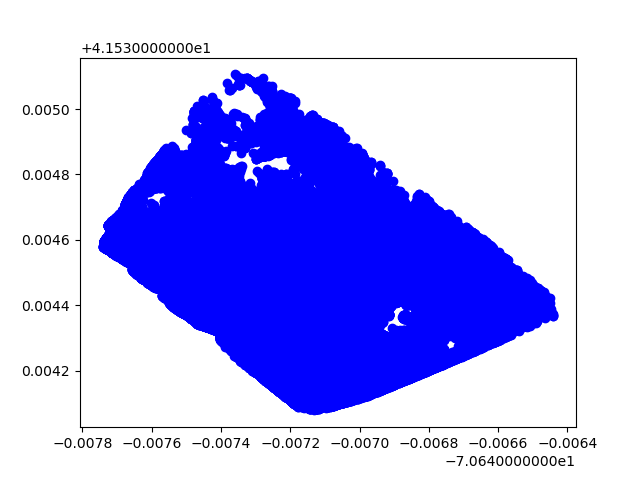

In [35]:
# lon_dense3d,lat_dense3d,newDEM to ECEF
fig=plt.figure()
plt.scatter(lon_dense3d,lat_dense3d,color='blue')
ecef_x2,ecef_y2,ecef_z2 = transform(outProj,ecefProj,lon_dense3d,lat_dense3d,newDEM)

In [36]:
from lmfit import minimize, Parameters, Parameter, printfuncs, fit_report

In [46]:
params = Parameters()

d1 = Parameter('d1', 0.0091,max=50,min=-50 )  
params.add(d1)
d2 = Parameter('d2', 0.000,max=50,min=-50 )  
params.add(d2)
d3 = Parameter('d3', 0.000,max=50,min=-50 )  
params.add(d3)

t1 = Parameter('t1', -1584484.26 )  
t2 = Parameter('t2',4511281.41)  
t3 = Parameter('t3',-4207039.55)
#t4 = Parameter('t4',0)  
#t5 = Parameter('t5',0)  
#t6 = Parameter('t6',0)

th1 = Parameter('th1',-0.57735416)  
th2 = Parameter('th2',0.03723790)  
th3 = Parameter('th3',2.51167871) 

l1 = Parameter('l1',-7.31327153)  
l2 = Parameter('l2',9.21210135)  
l3 = Parameter('l3',-0.12837353) 

a1 = Parameter('a1', 0.08544341)  
a2 = Parameter('a2',50.1746194)  
a3 = Parameter('a3',-0.02756591) 

params.add(t1)
params.add(t2)
params.add(t3)
#params.add(t4)
#params.add(t5)
#params.add(t6)

params.add(th1)
params.add(th2)
params.add(th3)

params.add(l1)
params.add(l2)
params.add(l3)

params.add(a1)
params.add(a2)
params.add(a3)

#m1 = Parameter('m1',10) 
#params.add(m1)
#c1 = Parameter('c1',10) 
#params.add(c1)


fit_kws={'xtol':1e-15,'ftol':1e-12}

In [47]:
def smooth(x,window_len,window):
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]

    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')
    y=np.convolve(w/w.sum(),s,mode='valid')
    return(y)

#### Find the relationshio between point cloud and real values above MSL

In [77]:
def geopixsparse(params,lon,lat,DEM,x,y,z):
    t1 = params['t1'].value
    t2 = params['t2'].value  
    t3 = params['t3'].value   
    #t4 = params['t4'].value
    #t5 = params['t5'].value  
    #t6 = params['t6'].value     
    
    th1 = params['th1'].value
    th2 = params['th2'].value  
    th3 = params['th3'].value  
    
    l1 = params['l1'].value
    l2 = params['l2'].value  
    l3 = params['l3'].value  
    
    a1 = params['a1'].value
    a2 = params['a2'].value  
    a3 = params['a3'].value      
    
    t=np.zeros(3)
    t[0] = t1
    t[1] = t2
    t[2] = t3

    
    R1=np.zeros((3,3))
    R1[0,0] =1
    R1[0,1] =0
    R1[0,2] =0
    R1[1,0] =0
    R1[1,1] =np.cos(th1)
    R1[1,2] =-np.sin(th1)
    R1[2,0] =0
    R1[2,1] =np.sin(th1)
    R1[2,2] =np.cos(th1)
 
    R2=np.zeros((3,3))
    R2[0,0] = np.cos(th2) 
    R2[0,1] = 0
    R2[0,2] = np.sin(th2)
    R2[1,0] =0
    R2[1,1] =1
    R2[1,2] =0
    R2[2,0] =-np.sin(th2)
    R2[2,1] =0
    R2[2,2] =np.cos(th2)
    
    R3=np.zeros((3,3))
    R3[0,0] = np.cos(th3) 
    R3[0,1] = -np.sin(th3)
    R3[0,2] =0
    R3[1,0] =np.sin(th3)
    R3[1,1] =np.cos(th3)
    R3[1,2] =0
    R3[2,0] =0
    R3[2,1] =0
    R3[2,2] =1

    R=np.matmul(R3,R2) 
    R = np.matmul(R,R1)
    
    L=np.zeros((3,3))
    L[0,0] = l1
    L[1,1] = l2
    L[2,2] = l3
    
    
    S = np.zeros((3,3))
    S[0,0] = 1
    S[1,1] = 1
    S[2,2] = 1
    S[1,0] = a1
    S[2,0] = a2
    S[2,1] = a3
    
    U = np.matmul(R,L)
    U = np.matmul(U,S)

    
    idx=np.isfinite(DEM)
    DEM=DEM[idx]
    lon=lon[idx]
    lat=lat[idx]
    x=x[idx]
    y=y[idx]
    z=z[idx]
    
    c1 = 1#params['c1'].value
    m1 = 1#params['m1'].value
    
    
    
    window_len_meas = int(m1)
    window_len_calc = int(c1)
    window='flat'
    
    d1 = params['d1'].value
    d2 = params['d2'].value
    d3 = params['d3'].value
    


    #newDEM=newDEM[np.isfinite(newDEM)]
    smooth_DEM = smooth(DEM,window_len_meas,window)
    smooth_lon = smooth(lon,window_len_meas,window)
    smooth_lat = smooth(lat,window_len_meas,window)
    
    smooth_x= smooth(x,window_len_calc,window)
    smooth_y= smooth(y,window_len_calc,window)
    smooth_z= smooth(z,window_len_calc,window)
    
    n1=-41000#-len(smooth_x)#
    n2=-1000
    o1=abs(n1)-1050
    o2=o1-50
    l = abs(abs(n1) - abs(n2))

    pos=np.linspace(0,l,l)
    # interpolated smooth calc z3d
    interp_calc_x=interp1d(pos,smooth_x[n1:n2])
    interp_calc_y=interp1d(pos,smooth_y[n1:n2])
    interp_calc_z=interp1d(pos,smooth_z[n1:n2])
    
    #interp the smooth DEM
    interp_dem=interp1d(pos,smooth_DEM[n1:n2])
    interp_lon=interp1d(pos,smooth_lon[n1:n2])
    interp_lat=interp1d(pos,smooth_lat[n1:n2])
    
    # the interpolated DEM on 50->450 points of the 500
    interpolated_smooth_dem = interp_dem(pos[50:o1])
    interpolated_smooth_lon = interp_lon(pos[50:o1])
    interpolated_smooth_lat = interp_lat(pos[50:o1])
    
    
    # new, shifted smooth calc z3d points
    new_pos=np.linspace(50+d1,o1+d1,o2) 
    new_pos1=np.linspace(50+d2,o1+d2,o2)
    new_pos2=np.linspace(50+d3,o1+d3,o2)
    interp_smooth_calcDEM = interp_calc_z(new_pos)
    interp_smooth_calc_lon = interp_calc_x(new_pos1)
    interp_smooth_calc_lat = interp_calc_y(new_pos2)
    
    
    tx = block_reduce(interp_smooth_calc_lon,10)
    n = len(interp_smooth_calcDEM)

    X = np.zeros((3,n))
    x = np.zeros((3,n))

    #X[0,:] = interpolated_smooth_lon
    #X[1,:] = interpolated_smooth_lat
    #X[2,:] = interpolated_smooth_dem

    #x[0,:] = interp_smooth_calc_lon
    #x[1,:] = interp_smooth_calc_lat
    #x[2,:] = interp_smooth_calcDEM
    """
    x[0,:] = block_reduce(interp_smooth_calc_lon,10)
    x[1,:] = block_reduce(interp_smooth_calc_lat,10)
    x[2,:] = block_reduce(interp_smooth_calcDEM,10)

    X[0,:] = block_reduce(interpolated_smooth_lon,10)
    X[1,:] = block_reduce(interpolated_smooth_lat,10)
    X[2,:] = block_reduce(interpolated_smooth_dem,10)

    """
    X[0,:] = interpolated_smooth_lon
    X[1,:] = interpolated_smooth_lat
    X[2,:] = interpolated_smooth_dem
    
    x[0,:] = interp_smooth_calc_lon
    x[1,:] = interp_smooth_calc_lat
    x[2,:] = interp_smooth_calcDEM
    

    res=np.zeros((3,n))
    full = np.zeros((3,n))
    
    
    for i in range(n):
        full[:,i] =  np.matmul(U ,x[:,i]) - t
        res[0,i] = (X[0,i] - full[0,i])#/X[0,i]
        res[1,i] = (X[1,i] - full[1,i])#/X[1,i]
        res[2,i] = (X[2,i] - full[2,i])#/X[2,i]
        
    #print(U)
    #print(t)
    #print(x[:,0])
    #print(X[:,0])
    #print(full[:,0])
    #print(res[:,0])
    
    #print(np.nanmean(full[2,:]),np.nanmean(X[2,:]))
    #full=np.array(full)
    #res=np.array(res)
    
    """
    if(abs(np.nanmean(res[0,:])) <=10):
        fig, ax = plt.subplots(2, sharex=True,figsize=(5,5))
        ax[0].plot(X[0,:],label='meas',color='red')
        ax[0].plot(full[0,:],label='calc',color='black',alpha=0.5)
        ax[0].set_ylabel('Elevation [ft]')
        ax[0].legend()
        ax[1].plot(res[0,:],label='residual')
        ax[1].set_ylabel('Elevation [ft]')
        ax[1].set_xlabel('3D Point Counter')
        ax[1].legend()
        #display(fig)
        plt.show()
        plt.close()
    """

    
    print(np.nanmean(res[0,:]),np.nanmean(res[1,:]),np.nanmean(res[2,:]))
    #print(np.nanmean(t))
    return(res[:,:])

In [78]:
#lon/lat fit
#lsqFit = minimize(geopixsparse, params, args=(lon_dense3d,lat_dense3d,newDEM,dense_x3d,dense_y3d,dense_z3d),method='leastsq',max_nfev=1000,**fit_kws)
lsqFit = minimize(geopixsparse, params, args=(ecef_x2,ecef_y2,ecef_z2,dense_x3d[:],dense_y3d[:],dense_z3d[:]),method='leastsq',max_nfev=3000,**fit_kws)
print(fit_report(lsqFit))

0.010048930417526896 0.00428766240970346 -0.007699194247309202
0.010048930417526896 0.00428766240970346 -0.007699194247309202
0.010048930417526896 0.00428766240970346 -0.007699194247309202
0.01004893041758525 0.004287662409586753 -0.007699194247589299
0.010048930742276044 0.004287662316851299 -0.007699194481960477
0.010048930450765076 0.004287662455919467 -0.007699194208725839
0.033659585868714516 0.00428766240970346 -0.007699194247309202
0.010048930417526896 0.07151099430070373 -0.007699194247309202
0.010048930417526896 0.00428766240970346 0.05499058042239762
0.010048911080976953 0.0042876446220491615 -0.00769905609386812
0.010048931852954074 0.004287661361673796 -0.0076991973011602734
0.010049295030950912 0.004287141594863065 -0.007699194247309202
0.01004899805947382 0.0042876130974569115 -0.007699191128685697
0.010048823054281196 0.004287507369143324 -0.007699316966167667
0.010048962768335315 0.004287701844725581 -0.007699272372808896
0.010048934719105132 0.00428766862108818 -0.0076

0.0026741511372027726 0.0035014561903114454 -0.006446186908588448
0.002673847934775017 0.0035019345061484733 -0.0064461866364741984
0.0026736696496813613 0.0035018294819754393 -0.006446309887306919
0.002673806814187414 0.0035020267942168734 -0.006446266824164822
0.0026737811175679186 0.0035019903480866576 -0.006446181899496823
0.0026737545957826172 0.0035019525427389935 -0.006446128018494499
0.002673776778643414 0.0035019840870547415 -0.006446186980573381
5.5984762925561286e-05 0.00031093367520150235 -0.0005032603757544643
-7.668430203301156e-05 6.1710722240290246e-06 4.988364884653187e-05
-7.668430227809643e-05 6.171072107321935e-06 4.988364821631359e-05
-7.668430236562676e-05 6.171072644174547e-06 4.9883647912875156e-05
-7.66843019629873e-05 6.171072294053278e-06 4.988364868314195e-05
0.023533970217843703 6.1710722240290246e-06 4.988364884653187e-05
-7.668430203301156e-05 0.06722950482586945 4.988364884653187e-05
-7.668430203301156e-05 6.1710722240290246e-06 0.06273966297516623
-7.66

4.884515824216537e-05 3.254191385101256e-05 -0.00010978306874744874
4.884515732017936e-05 3.2541914061085325e-05 -0.00010978306802386478
0.023659499211372215 3.2541914808010694e-05 -0.00010978306823393755
4.884515716262479e-05 0.067255876599776 -0.00010978306823393755
4.884515716262479e-05 3.2541914808010694e-05 0.06257999718940833
4.8831180566665075e-05 3.2522279377046384e-05 -0.00010964320722808664
4.884522590893589e-05 3.254186719151816e-05 -0.00010978324093708867
4.922187762839117e-05 3.2012467961151496e-05 -0.00010978306823393755
4.891646700913558e-05 3.2492373255373244e-05 -0.00010978289868187784
4.8738127121501104e-05 3.238743876006669e-05 -0.00010990611181820843
4.887572555618365e-05 3.258562943242248e-05 -0.00010986454224676118
4.884954245485608e-05 3.254824198950502e-05 -0.00010977802833164097
4.88230782294912e-05 3.251033639045138e-05 -0.00010972421877739722
4.884517400345781e-05 3.2541939386523754e-05 -0.00010978311290941142
-1.5367621096098482e-05 7.554422317068081e-05 -7.

0.001487581822075846 0.0021672962722426893 -0.004113246247354418
0.0014875551140610419 0.002167257977075371 -0.004113158169284202
0.0014875287201633692 0.002167220062863334 -0.004113104543823721
0.0014875507134626757 0.0021672516288399175 -0.004113163235375569
0.005876837189823977 0.008447424637172418 -0.015775379119580962
0.005876837189847319 0.008447424637312467 -0.015775379119604305
0.0058768371896664225 0.008447424637265784 -0.015775379119534277
0.005876837189613905 0.008447424638222782 -0.015775379119137473
0.02948749007988035 0.008447424637172418 -0.015775379119580962
0.005876837189823977 0.07567076118478556 -0.015775379119580962
0.005876837189823977 0.008447424637172418 0.04691440393202903
0.005876824152101541 0.008447406155881203 -0.015775237875992904
0.005876837228570731 0.00844742461170693 -0.015775379227138217
0.005877217972081594 0.008446892371662615 -0.015775379119580962
0.005876908576644649 0.008447375090134547 -0.015775379011043367
0.005876730250971938 0.0084472702966214

0.003032972109422349 0.004488049657352474 -0.008142542777218877
0.003032940966158844 0.004488004883517859 -0.00814244315396985
0.0030329143392846436 0.0044879665601541075 -0.008142390240282567
0.0030329364003382512 0.004487998290641004 -0.00814244848694699
0.0026241468965428364 0.003824838594997997 -0.007368294749558345
0.002624146896501989 0.003824838594811266 -0.007368294749675052
0.002624146896945476 0.0038248385944611445 -0.007368294748998152
0.0026241468965136597 0.0038248385947879243 -0.007368294749535004
0.026234795595647623 0.003824838594997997 -0.007368294749558345
0.0026241468965428364 0.07104818073054658 -0.007368294749558345
0.0026241468965428364 0.003824838594997997 0.055321499477922545
0.0026241373371293205 0.0038248250621107215 -0.00736814787639375
0.0026241469194232614 0.0038248385807597325 -0.007368294833073939
0.002624542953342638 0.0038242957384365243 -0.007368294749558345
0.0026242183206572588 0.0038247890485203205 -0.007368294663288465
0.002624040558872357 0.003824

0.004365862693998235 0.006365815544650332 -0.011965628011376225
0.004365824429414009 0.006365760489411297 -0.011965510447983418
0.00436579741431951 0.006365721585686531 -0.011965458474885253
0.004365819671913692 0.006365753620989004 -0.011965516279836682
0.015134557058199083 0.02171332593400377 -0.040989627299041376
0.0014189045463821718 0.0020656388569016354 -0.003850240804871222
0.0014189045463821718 0.0020656388568549527 -0.0038502408049645876
0.0014189045465980799 0.0020656388563647828 -0.0038502408049412465
0.001418904546026215 0.0020656388564581486 -0.0038502408048478806
0.025029546726228934 0.0020656388569016354 -0.003850240804871222
0.0014189045463821718 0.06928899123699855 -0.003850240804871222
0.0014189045463821718 0.0020656388569016354 0.05883957018641601
0.001418900587181689 0.0020656332428237996 -0.003850084965917886
0.0014189045498542077 0.0020656388537272025 -0.003850240835588528
0.0014193250879850753 0.0020650791010135474 -0.003850240804871222
0.0014189760293578145 0.00

0.006350250531543504 0.009176393826036973 -0.01743699405552413
0.006350074800882106 0.00917629290383804 -0.017437120914053087
0.0063502332844414325 0.009176521731101742 -0.017437131600617838
0.0063501841802894605 0.009176450844475985 -0.017436987754811804
0.00635015660619718 0.009176411036247934 -0.017436937315314822
0.006350179082587977 0.009176443482779508 -0.017436994264173066
0.005698284972453243 0.00816664161221276 -0.016535790518911225
0.005698284972575785 0.008166641612236101 -0.016535790519097954
0.005698284973054284 0.00816664161022874 -0.016535790517510737
0.005698284972552444 0.00816664161039213 -0.016535790518094274
0.029308915743598465 0.00816664161221276 -0.016535790518911225
0.005698284972453243 0.07539000982479344 -0.016535790518911225
0.005698284972453243 0.00816664161221276 0.046154047480730674
0.005698290316079904 0.008166649360513142 -0.016535618816243304
0.005698284971122782 0.008166641612819636 -0.016535790529811665
0.005698747179356583 0.008166053101845216 -0.016

0.0041707733008756135 0.006109757671916956 -0.012633330934473259
0.0041703361477632836 0.006110328834896025 -0.012633330903055712
0.004170162534880403 0.0061102308748864145 -0.012633460296836114
0.004170335786268908 0.006110480995475312 -0.012633504106483439
0.004170270352320918 0.006110386631094424 -0.012633323688923677
0.004170241772067642 0.006110345397289273 -0.012633275301230693
0.004170264652632597 0.006110378397362573 -0.012633330986244525
0.0034410813874576735 0.005080461940333658 -0.010941779299832899
0.0034410813871775764 0.005080461939960195 -0.010941779299412754
0.003441081387393485 0.005080461940613755 -0.010941779299412754
0.003441081387743606 0.0050804619411039245 -0.010941779299762875
0.02705169702461106 0.005080461940333658 -0.010941779299832899
0.0034410813874576735 0.07230385250465612 -0.010941779299832899
0.0034410813874576735 0.005080461940333658 0.05174809222742168
0.003441098909107338 0.005080487396390665 -0.010941585531915751
0.0034410813684285827 0.005080461953

3.004412935873993e-05 6.105916656292322e-05 -7.415632080090674e-05
2.3528869166960917e-05 6.289486474541942e-05 -8.030007009798273e-05
2.3528869137784145e-05 6.289486467539517e-05 -8.030006995793422e-05
2.352886891020532e-05 6.28948637884213e-05 -8.030007261885586e-05
2.3528869032747764e-05 6.289486486212652e-05 -8.030007086824953e-05
0.023634133097624643 6.289486474541942e-05 -8.030007009798273e-05
2.3528869166960917e-05 0.06728630126155166 -8.030007009798273e-05
2.3528869166960917e-05 6.289486474541942e-05 0.06260959474022096
2.355532389236871e-05 6.293324690620254e-05 -8.008950714367375e-05
2.3528840672925003e-05 6.289488467899033e-05 -8.030011131892676e-05
2.40880565514746e-05 6.223923344641252e-05 -8.030007009798273e-05
2.360039868539101e-05 6.28453397885301e-05 -8.030003226154431e-05
2.3428661186238728e-05 6.275002928660776e-05 -8.043149896993075e-05
2.36156620061898e-05 6.302005146865856e-05 -8.050421129137203e-05
2.3535045889675392e-05 6.290379286111149e-05 -8.029196950557984e-

3.6375567802510464e-05 -9.8217271716523e-07 -1.952602927173887e-06


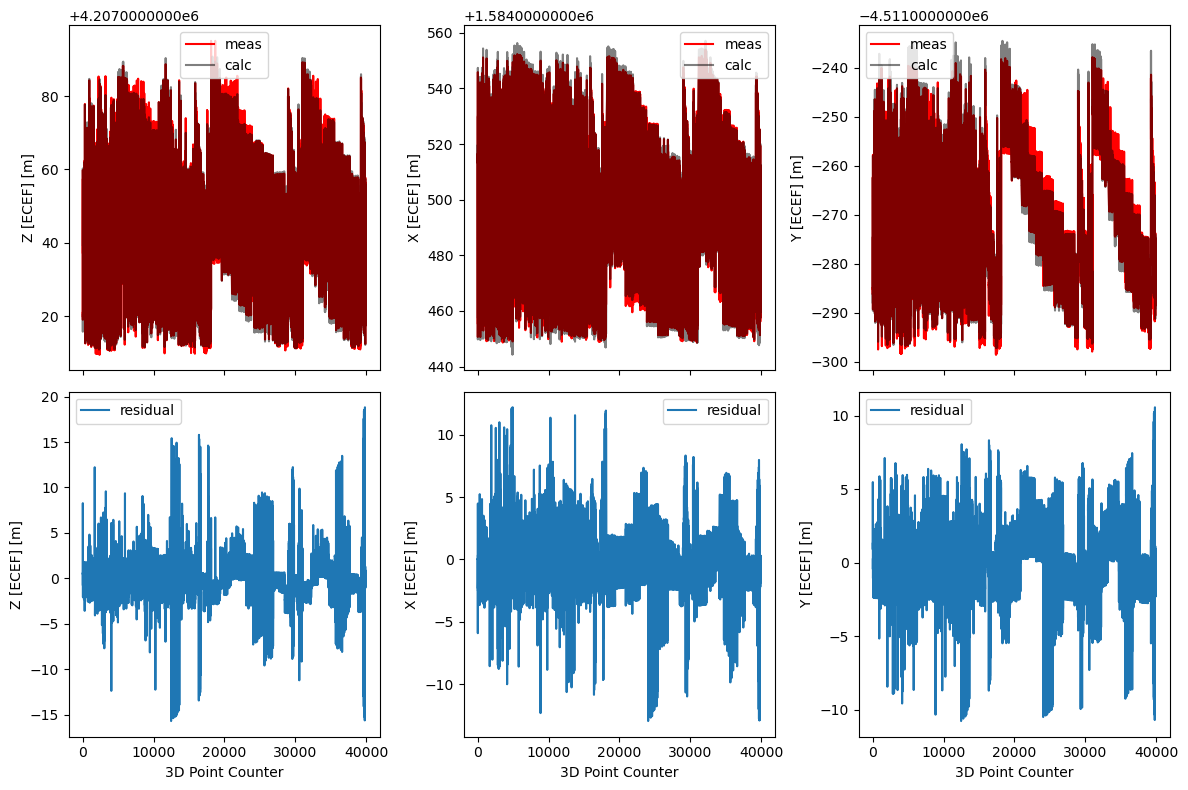

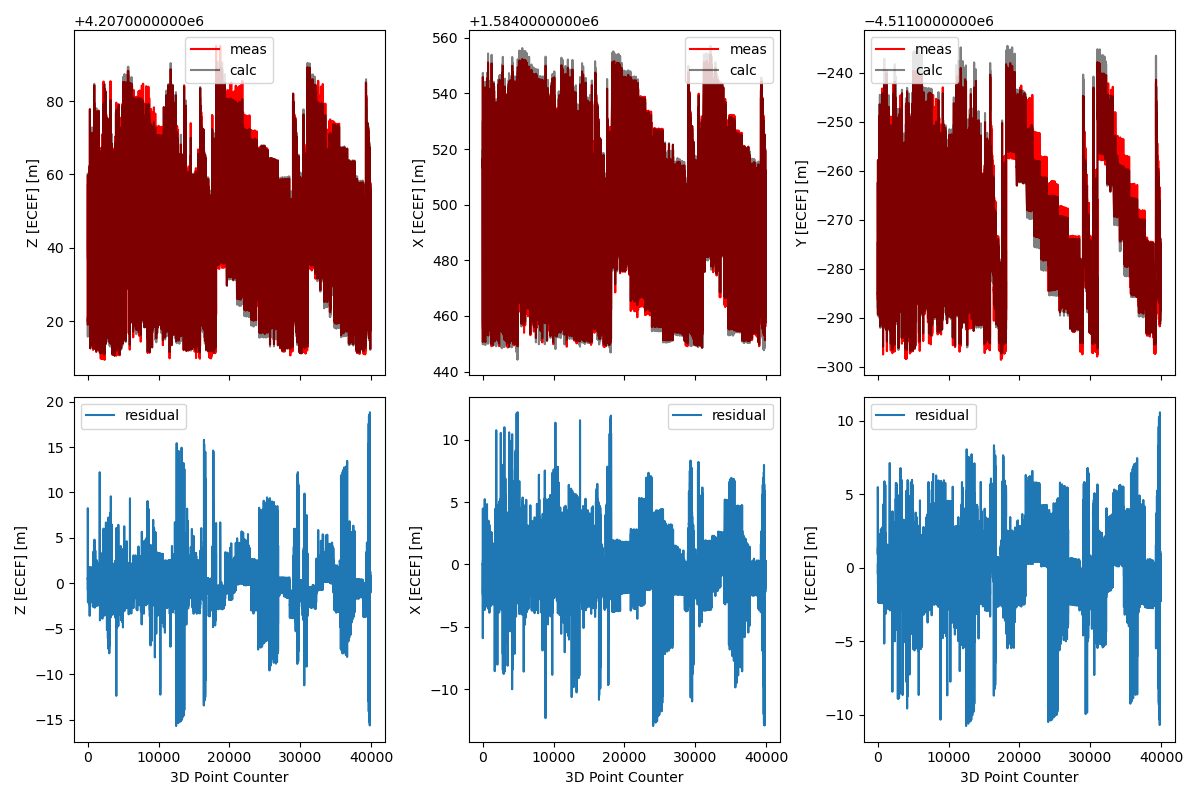

In [81]:
# Use running mean?
t1 = lsqFit.params['t1'].value
t2 = lsqFit.params['t2'].value  
t3 = lsqFit.params['t3'].value   
    
#t4 = lsqFit.params['t4'].value
#t5 = lsqFit.params['t5'].value  
#t6 = lsqFit.params['t6'].value 
    
th1 = lsqFit.params['th1'].value
th2 = lsqFit.params['th2'].value  
th3 = lsqFit.params['th3'].value  
    
l1 = lsqFit.params['l1'].value
l2 = lsqFit.params['l2'].value  
l3 = lsqFit.params['l3'].value  
    
a1 = lsqFit.params['a1'].value
a2 = lsqFit.params['a2'].value  
a3 = lsqFit.params['a3'].value      
    
t=np.zeros(3)
t[0] = t1
t[1] = t2
t[2] = t3

    
R1=np.zeros((3,3))
R1[0,0] =1
R1[0,1] =0
R1[0,2] =0
R1[1,0] =0
R1[1,1] =np.cos(th1)
R1[1,2] =-np.sin(th1)
R1[2,0] =0
R1[2,1] =np.sin(th1)
R1[2,2] =np.cos(th1)
 
R2=np.zeros((3,3))
R2[0,0] = np.cos(th2) 
R2[0,1] = 0
R2[0,2] = np.sin(th2)
R2[1,0] =0
R2[1,1] =1
R2[1,2] =0
R2[2,0] =-np.sin(th2)
R2[2,1] =0
R2[2,2] =np.cos(th2)
    
R3=np.zeros((3,3))
R3[0,0] = np.cos(th3) 
R3[0,1] = -np.sin(th3)
R3[0,2] =0
R3[1,0] =np.sin(th3)
R3[1,1] =np.cos(th3)
R3[1,2] =0
R3[2,0] =0
R3[2,1] =0
R3[2,2] =1

R=np.matmul(R3,R2) 
R = np.matmul(R,R1)
    
L=np.zeros((3,3))
L[0,0] = l1
L[1,1] = l2
L[2,2] = l3
    
    
S = np.zeros((3,3))
S[0,0] = 1
S[1,1] = 1
S[2,2] = 1
S[1,0] = a1
S[2,0] = a2
S[2,1] = a3
    
U = np.matmul(R,L)
U = np.matmul(U,S)


idx=np.isfinite(newDEM)
DEM=ecef_z2[idx]#newDEM[idx]
lon=ecef_x2[idx]#lon_dense3d[idx]
lat=ecef_y2[idx]#lat_dense3d[idx]

x1=dense_x3d[:]
y1=dense_y3d[:]
z1=dense_z3d[:]

x1=x1[idx]
y1=y1[idx]
z1=z1[idx]

    
window_len_meas =1#200#350
window_len_calc = 1#0#300#100
window='flat'
    
d1 = lsqFit.params['d1'].value
d2 = lsqFit.params['d2'].value
d3 = lsqFit.params['d3'].value
    


#newDEM=newDEM[np.isfinite(newDEM)]
smooth_DEM = smooth(DEM,window_len_meas,window)
smooth_lon = smooth(lon,window_len_meas,window)
smooth_lat = smooth(lat,window_len_meas,window)

    
smooth_x= smooth(x1,window_len_calc,window)
smooth_y= smooth(y1,window_len_calc,window)
smooth_z= smooth(z1,window_len_calc,window)
    
n1=-41000#len(smooth_x)#281000
n2=-1000
o1=abs(n1)-1050
o2=o1-50
l = abs(abs(n1) - abs(n2))

pos=np.linspace(0,l,l)
# interpolated smooth calc z3d
interp_calc_x=interp1d(pos,smooth_x[n1:n2])
interp_calc_y=interp1d(pos,smooth_y[n1:n2])
interp_calc_z=interp1d(pos,smooth_z[n1:n2])
    
#interp the smooth DEM
interp_dem=interp1d(pos,smooth_DEM[n1:n2])
interp_lon=interp1d(pos,smooth_lon[n1:n2])
interp_lat=interp1d(pos,smooth_lat[n1:n2])
    
# the interpolated DEM on 50->450 points of the 500
interpolated_smooth_dem = interp_dem(pos[50:o1])
interpolated_smooth_lon = interp_lon(pos[50:o1])
interpolated_smooth_lat = interp_lat(pos[50:o1])
    
    
# new, shifted smooth calc z3d points
new_pos=np.linspace(50+d1,o1+d1,o2)  
new_pos2=np.linspace(50+d2,o1+d2,o2)  
new_pos3=np.linspace(50+d3,o1+d3,o2)  
interp_smooth_calcDEM = interp_calc_z(new_pos)
interp_smooth_calc_lon = interp_calc_x(new_pos2)
interp_smooth_calc_lat = interp_calc_y(new_pos3)
    
#tx = block_reduce(interp_smooth_calc_lon,10)
n = len(interp_smooth_calcDEM)

X = np.zeros((3,n))
x = np.zeros((3,n))
    
X[0,:] = interpolated_smooth_lon
X[1,:] = interpolated_smooth_lat
X[2,:] = interpolated_smooth_dem
    
x[0,:] = interp_smooth_calc_lon
x[1,:] = interp_smooth_calc_lat
x[2,:] = interp_smooth_calcDEM

"""
x[0,:] = block_reduce(interp_smooth_calc_lon,10)
x[1,:] = block_reduce(interp_smooth_calc_lat,10)
x[2,:] = block_reduce(interp_smooth_calcDEM,10)

X[0,:] = block_reduce(interpolated_smooth_lon,10)
X[1,:] = block_reduce(interpolated_smooth_lat,10)
X[2,:] = block_reduce(interpolated_smooth_dem,10)
"""

#n=len(interp_smooth_calcDEM)
res=np.zeros((3,n))
full = np.zeros((3,n))
    
    
for i in range(n):
    full[:,i] =  np.matmul(U ,x[:,i]) - t
    

# convert these to lon/lat/z
# lon_dense3d,lat_dense3d,newDEM to ECEF
#print(full[0,0],full[1,0],full[2,0])
#full[0,:],full[1,:],full[2,:] = transform(ecefProj,outProj,full[0,:],full[1,:],full[2,:])
#res[0,:],res[1,:],res[2,:] = transform(ecefProj,outProj,res[0,:],res[1,:],res[2,:])
#X[0,:],X[1,:],X[2,:] = transform(ecefProj,outProj,X[0,:],X[1,:],X[2,:])
#print(full[0,0],full[1,0],full[2,0])

res[0,:] = X[0,:] - full[0,:]
res[1,:] = X[1,:] - full[1,:]
res[2,:] = X[2,:] - full[2,:] 

print(np.nanmean(res[0,:]),np.nanmean(res[1,:]),np.nanmean(res[2,:]))

fig, ax = plt.subplots(2,3, sharex=True,figsize= (12,8))

ax[0,2].plot(X[1,:],label='meas',color='red')
ax[0,2].plot(full[1,:],label='calc',color='black',alpha=0.5)
#ax[0,2].set_ylabel('Lat [Degrees]')
ax[0,2].set_ylabel('Y [ECEF] [m]')
ax[0,2].legend()
ax[1,2].plot(res[1,:],label='residual')
#ax[1,2].set_ylabel('Lat [Degrees]')
ax[1,2].set_ylabel('Y [ECEF] [m]')
ax[1,2].set_xlabel('3D Point Counter')
ax[1,2].legend()

ax[0,1].plot(X[0,:],label='meas',color='red')
ax[0,1].plot(full[0,:],label='calc',color='black',alpha=0.5)
#ax[0,1].set_ylabel('Lon [Degrees]')
ax[0,1].set_ylabel('X [ECEF] [m]')
ax[0,1].legend()
ax[1,1].plot(res[0,:],label='residual')
#ax[1,1].set_ylabel('Lon [Degrees]')
ax[1,1].set_ylabel('X [ECEF] [m]')
ax[1,1].set_xlabel('3D Point Counter')
ax[1,1].legend()


ax[0,0].plot(X[2,:],label='meas',color='red')
ax[0,0].plot(full[2,:],label='calc',color='black',alpha=0.5)
#ax[0,0].plot(x[2,:],label='calc',color='black',alpha=0.5)
#ax[0,0].set_ylabel('Elevation [m]')
ax[0,0].set_ylabel('Z [ECEF] [m]')
ax[0,0].legend()
ax[1,0].plot(res[2,:],label='residual')
#ax[1,0].set_ylabel('Elevation [m]')
ax[1,0].set_ylabel('Z [ECEF] [m]')
ax[1,0].set_xlabel('3D Point Counter')
ax[1,0].legend()

fig.tight_layout()
display(fig)
#plt.show()
#plt.close()

In [42]:
print(full.shape,lon_dense3d.shape,x1.shape,y1.shape,z1.shape)

(3, 337629) (357482,) (338729,) (338729,) (338729,)


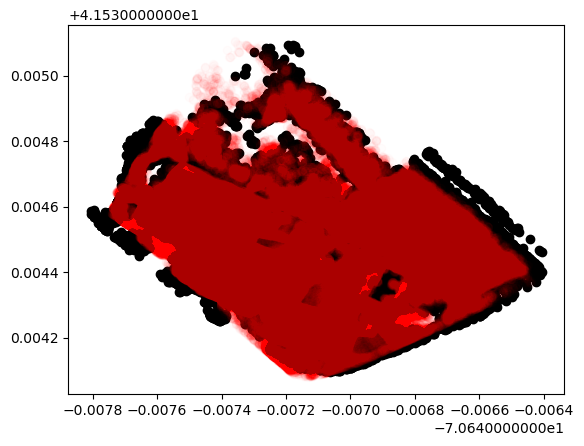

C:\Users\e.conway\Research\3DReconstruction\Colmap\COLMAP-3.7-windows-cuda\image1.kml


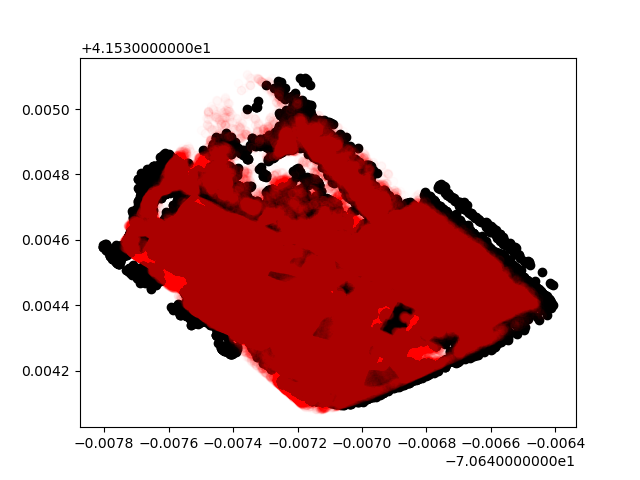

In [64]:
ns = 100



x=full[0,:]
y=full[1,:]
z=full[2,:]


#idx=np.isfinite(newDEM)
#DEM=ecef_z2[idx]#newDEM[idx]
#x=x[idx]#lon_dense3d[idx]
#y=y[idx]



#idx=np.isfinite(x)
#x=x[idx]
#y=y[idx]
#z=z[idx]
#print(x.shape,y.shape,z.shape)

#idx=np.isfinite(y)
#x=x[idx]
#y=y[idx]
#z=z[idx]

#print(x.shape,y.shape,z.shape)

#idx=np.isfinite(z)
#x=x[idx]
#y=y[idx]
#z=z[idx]

fig=plt.figure()
plt.scatter(x,y,color='black')
plt.scatter(lon_dense3d,lat_dense3d,color='red',alpha=0.01)
#plt.scatter(kp_sparse[0,:],kp_sparse[1,:])
display(fig)


vmax = np.nanmax(z)
vmin = np.nanmin(z)

color = 255*z.flatten() / vmax

idx = np.isfinite(z.flatten())

fname = 'image1.'
fname=fname+'kml'
fname = os.path.join(os.getcwd(),fname)
print(fname)

#make_kml(x.flatten(),y.flatten(),z.flatten(),color,fname)


### Let us try a full RT transformation of the point cloud [dense_x3d,dense_y3d,dense_z3d],
### to [lon,lat,DTM]

### Obtain GEDI beam locations for this area

### Minimization routine for GEDI Vs. 3D points